In [1]:
import pickle
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [2]:
import numpy as np
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


In [3]:
# Tìm siêu tham số cho mô hình 
import tensorflow as tf
from tensorflow.keras import backend as K
import keras_tuner as kt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight as cw_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def build_tabular_vgg_model(hp):
    """
    Xây dựng mô hình CNN (Tabular-VGG) với focal loss tunable.
    Mô hình này thiết kế cho dữ liệu bảng nhưng sử dụng kiến trúc CNN
    lấy cảm hứng từ VGG (nhiều khối Conv - MaxPool lặp lại).
    """
    model = Sequential()
    
    # 1. Định nghĩa các siêu tham số cấu trúc mô hình
    num_blocks   = hp.Int('num_blocks', 2, 4, default=3)
    kernel_size  = hp.Choice('kernel_size',  [2, 3, 5])
    filters      = hp.Int('initial_filters', 16, 64, step=16, default=32)
    input_shape  = (10, 1)  # Dữ liệu đầu vào có 10 features, reshape thành dạng 3D (10,1)

    # Block đầu tiên
    model.add(Conv1D(filters, kernel_size, activation='relu',
                     padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # Các block tiếp theo (tăng gấp đôi filters mỗi lần)
    for i in range(1, num_blocks):
        filters *= 2
        model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    # 2. Phần Fully-connected (mạng thần kinh truyền thống)
    model.add(Flatten())
    fc1 = hp.Int('fc_units_1', 128, 1024, step=128, default=512)
    model.add(Dense(fc1, activation='relu'))
    dropout = hp.Float('dropout_rate', 0.1, 0.5, step=0.1, default=0.3)
    model.add(Dropout(dropout))
    fc2 = hp.Int('fc_units_2', 64, 512, step=64, default=256)
    model.add(Dense(fc2, activation='relu'))
    model.add(Dropout(dropout))

    # 3. Output layer - 1 neuron với sigmoid cho bài toán phân loại nhị phân
    model.add(Dense(1, activation='sigmoid'))

    # 4. Cấu hình optimizer và learning rate
    learning_rate = hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3, 5e-3])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # 5. Cấu hình Focal Loss
    gamma = hp.Float('focal_gamma', 1.0, 3.0, step=0.5, default=2.0)
    alpha = hp.Float('focal_alpha', 0.25, 0.75, step=0.25, default=0.25)

    # Định nghĩa hàm focal loss
    def focal_loss(gamma, alpha):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
            p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
            alpha_t = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
            return -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
        return loss

    loss_fn = focal_loss(gamma, alpha)

    # 6. Compile mô hình
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name = 'average_precision')
        ]
    )
    return model

# def fit(self, hp, model, x, y, **kwargs):
#     # Lấy batch_size từ hyperparameter space
#     batch_size = hp.Choice('batch_size', [64, 128, 256, 512], default=128)
#     return model.fit(
#         x, y,
#         batch_size=batch_size,
#         **kwargs
#     )

In [7]:
from sklearn.preprocessing import StandardScaler
def prepare_data(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Chuẩn bị dữ liệu cho mô hình CNN:
    1. Fit scaler lên X_train (tránh data leakage)
    2. Transform X_train, X_val, X_test
    3. Reshape cho Conv1D
    """
    scaler = StandardScaler()
    # Fit trên train, transform cả 4 tập
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Reshape thành (samples, features, 1)
    X_train_r = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
    X_val_r   = X_val_scaled.reshape(-1,   X_val_scaled.shape[1],   1)
    X_test_r  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)

    return X_train_r, y_train, X_val_r, y_val, X_test_r, y_test, scaler

In [50]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight as cw_utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

# Chuẩn hóa & reshape train / valid / test
X_tr, y_tr, X_va, y_va, X_te, y_te, scaler = prepare_data(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test
)

# EarlyStopping để prune các model kém sớm
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Thiết lập Hyperband tuner
tuner = kt.Hyperband(
    build_tabular_vgg_model,            # hàm build model của bạn
    objective=kt.Objective('val_average_precision', direction='max'),
    max_epochs=30,                      # số epoch tối đa cho mỗi trial
    factor=4,   
    hyperband_iterations=1,
    directory='my_dir_vgg16',
    project_name='tabular_vgg_hyperband'                     
)

# Chạy search (Hyperband tự động điều phối số epoch cho từng trial)
tuner.search(
    X_tr, y_tr,
    epochs=50,
    validation_data=(X_va, y_va),
    callbacks=[stop_early],                    
)

# Lấy siêu tham số tốt nhất
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Xây model với siêu tham số tốt nhất
best_model = tuner.hypermodel.build(best_hps)

print("=== Best Hyperparameters (Hyperband) ===")
for p in ['num_blocks','kernel_size','initial_filters',
          'fc_units_1','fc_units_2','dropout_rate',
          'learning_rate','focal_gamma','focal_alpha']:
    print(f"{p}: {best_hps.get(p)}")


Reloading Tuner from my_dir_vgg16\tabular_vgg_hyperband\tuner0.json
=== Best Hyperparameters (Hyperband) ===
num_blocks: 4
kernel_size: 2
initial_filters: 64
fc_units_1: 896
fc_units_2: 512
dropout_rate: 0.5
learning_rate: 0.0005
focal_gamma: 2.5
focal_alpha: 0.5


In [41]:
X_tr_val = np.concatenate([X_train, X_val], axis=0)
y_tr_val = np.concatenate([y_train, y_val], axis=0)
#  Huấn luyện lại final model
#    best_model là model đã build với best_hps, nhưng chưa được train
best_model.fit(
    X_tr_val, y_tr_val,
    epochs=best_hps.get('tuner/epochs'),  # số epoch “điểm ngắt” đã tìm được
    batch_size=1024,                       # hoặc batch_size bạn muốn
    verbose=1
)


Epoch 1/30
27/27 [==============================] - 10s 248ms/step - loss: 0.0310 - auc: 0.5852 - precision: 0.0000e+00 - recall: 0.0000e+00 - average_precision: 0.5852
Epoch 2/30
27/27 [==============================] - 6s 235ms/step - loss: 0.0076 - auc: 0.8483 - precision: 0.2632 - recall: 0.0296 - average_precision: 0.8483
Epoch 3/30
27/27 [==============================] - 6s 237ms/step - loss: 0.0054 - auc: 0.8788 - precision: 0.2286 - recall: 0.0473 - average_precision: 0.8788
Epoch 4/30
27/27 [==============================] - 7s 244ms/step - loss: 0.0055 - auc: 0.8858 - precision: 0.4231 - recall: 0.0651 - average_precision: 0.8858
Epoch 5/30
27/27 [==============================] - 7s 254ms/step - loss: 0.0043 - auc: 0.9208 - precision: 0.1951 - recall: 0.0473 - average_precision: 0.9208
Epoch 6/30
27/27 [==============================] - 7s 244ms/step - loss: 0.0051 - auc: 0.8868 - precision: 0.2692 - recall: 0.0414 - average_precision: 0.8868
Epoch 7/30
27/27 [=============

211/211 [==============================] - 2s 6ms/step
Ngưỡng dự đoán tối ưu: 0.6654

=== Classification Report on Test ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.09      0.10      0.09        42

    accuracy                           0.99      6747
   macro avg       0.54      0.54      0.54      6747
weighted avg       0.99      0.99      0.99      6747



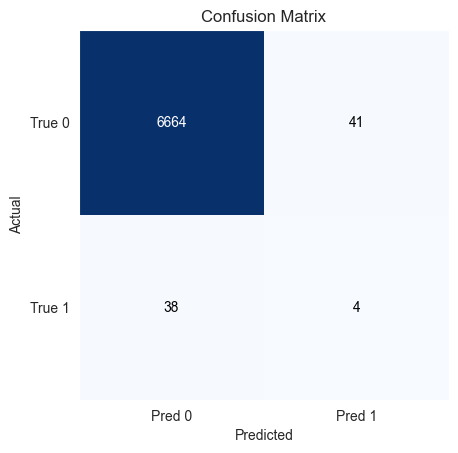

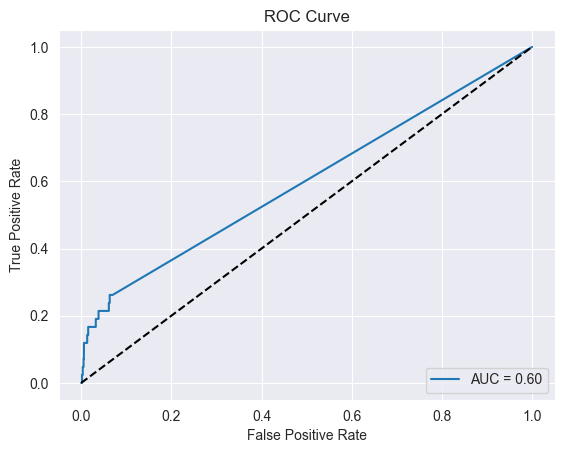

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
# Dự đoán trên test 
y_prob = best_model.predict(X_te).ravel()

# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred = (y_prob > optimal_threshold).astype(int)

# Classification Report
print("\n=== Classification Report on Test ===")
print(classification_report(y_te, y_pred, zero_division=0)) 

# Confusion Matrix 
cm = confusion_matrix(y_te, y_pred)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Tắt grid 
ax.grid(False)

ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_te, y_prob) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [31]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from imblearn.over_sampling import SMOTE

# 1) Áp dụng SMOTE chỉ trên X_train, y_train
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 2) Chuẩn hóa & reshape, dựa trên X_train_smote thay vì X_train ban đầu
X_tr, y_tr, X_va, y_va, X_te, y_te, scaler = prepare_data(
    X_train_smote, y_train_smote,  # train đã SMOTE
    X_val,         y_val,          # validation giữ nguyên
    X_test,        y_test          # test giữ nguyên
)

# 3) EarlyStopping để prune
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 4) Thiết lập Hyperband tuner
tuner = kt.Hyperband(
    build_tabular_vgg_model,
    objective=kt.Objective('val_average_precision', direction='max'),
    max_epochs=30,
    factor=4,
    hyperband_iterations=1,
    directory='my_dir_vgg16_smote',
    project_name='tabular_vgg_hyperband_smote'
)

# 5) Chạy search
tuner.search(
    X_tr, y_tr,
    epochs=30,
    validation_data=(X_va, y_va),
    callbacks=[stop_early]
)

# 6) Lấy kết quả
best_hps   = tuner.get_best_hyperparameters(1)[0]
best_model_smote = tuner.get_best_models(1)[0]

print("=== Best Hyperparameters (with SMOTE) ===")
for p in ['num_blocks','kernel_size','initial_filters',
          'fc_units_1','fc_units_2','dropout_rate',
          'learning_rate','focal_gamma','focal_alpha']:
    print(f"{p}: {best_hps.get(p)}")


Reloading Tuner from my_dir_vgg16_smote\tabular_vgg_hyperband_smote\tuner0.json
=== Best Hyperparameters (with SMOTE) ===
num_blocks: 3
kernel_size: 2
initial_filters: 16
fc_units_1: 768
fc_units_2: 448
dropout_rate: 0.1
learning_rate: 0.005
focal_gamma: 2.0
focal_alpha: 0.75


In [36]:
X_tr_val = np.concatenate([X_train, X_val], axis=0)
y_tr_val = np.concatenate([y_train, y_val], axis=0)
#  Huấn luyện lại final model

best_model_smote.fit(
    X_tr_val, y_tr_val,
    epochs=best_hps.get('tuner/epochs'),  # số epoch “điểm ngắt” đã tìm được
    batch_size=128,                       # hoặc batch_size bạn muốn
    verbose=1,
    callbacks=[stop_early]
)

Epoch 1/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0046 - auc: 0.9172 - precision: 0.2917 - recall: 0.0414 - average_precision: 0.9172
Epoch 2/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0049 - auc: 0.9049 - precision: 0.0000e+00 - recall: 0.0000e+00 - average_precision: 0.9049
Epoch 3/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0046 - auc: 0.9151 - precision: 0.2000 - recall: 0.0059 - average_precision: 0.9151
Epoch 4/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0045 - auc: 0.9152 - precision: 0.3158 - recall: 0.0355 - average_precision: 0.9152
Epoch 5/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0046 - auc: 0.9134 - precision: 0.2000 - recall: 0.0178 - average_precision: 0.9134
Epoch 6/8
211/211 [==============================] - 2s 10ms/step - loss: 0.0045 - auc: 0.9191 - precision: 0.1667 - recall: 0.0059 - average_precision: 0.9191
Epoch 7/8
211/211 [=============

211/211 [==============================] - 1s 3ms/step
Ngưỡng dự đoán tối ưu: 0.0919

=== Classification Report on Test ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.08      0.14      0.10        42

    accuracy                           0.98      6747
   macro avg       0.54      0.57      0.55      6747
weighted avg       0.99      0.98      0.99      6747



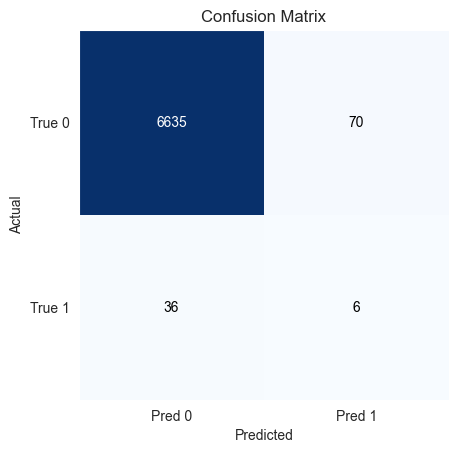

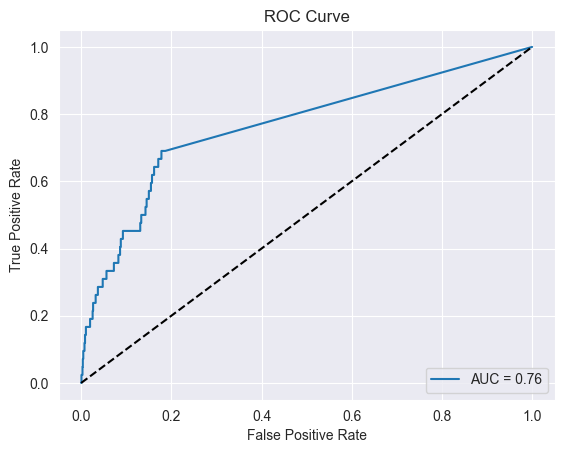

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Dự đoán trên test 
y_prob_smote = best_model_smote.predict(X_te).ravel()

# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_smote)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred_smote = (y_prob_smote > optimal_threshold).astype(int)

# Classification Report
print("\n=== Classification Report on Test ===")
print(classification_report(y_te, y_pred_smote, zero_division=0)) 

# Confusion Matrix 
cm = confusion_matrix(y_te, y_pred_smote)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_te, y_prob_smote) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [43]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 2. Fit scaler trên toàn bộ train_val, sau đó transform cả train_val và test
scaler = StandardScaler().fit(X_train_val)
X_train_val_s = scaler.transform(X_train_val)   # (n_train_val, n_features)
X_test_s      = scaler.transform(X_test)        # (n_test,       n_features)

# 3. Áp dụng SMOTE lên train_val đã scale
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_val_s, y_train_val)  
# X_res: (n_resampled, n_features), y_res: (n_resampled,)

# 4. (Nếu dùng Conv1D) Reshape về 3D: (samples, features, 1)
X_res_r   = X_res.reshape(-1, X_res.shape[1], 1)
X_test_r  = X_test_s.reshape(-1, X_test_s.shape[1], 1)


In [53]:
#  Huấn luyện lại final model
#    best_model là model đã build với best_hps, nhưng chưa được train
best_model.fit(
    X_res_r, y_res,
    epochs=best_hps.get('tuner/epochs'),  # số epoch “điểm ngắt” đã tìm được
    batch_size=1024,                       # hoặc batch_size bạn muốn
    verbose=1,
    callbacks=[stop_early]
)

Epoch 1/30
53/53 [==============================] - 13s 238ms/step - loss: 0.0011 - auc: 0.9999 - precision: 0.9949 - recall: 0.9981 - average_precision: 0.9999
Epoch 2/30
53/53 [==============================] - 14s 265ms/step - loss: 6.4204e-04 - auc: 1.0000 - precision: 0.9970 - recall: 0.9993 - average_precision: 1.0000
Epoch 3/30
53/53 [==============================] - 14s 261ms/step - loss: 5.3304e-04 - auc: 1.0000 - precision: 0.9974 - recall: 0.9991 - average_precision: 1.0000
Epoch 4/30
53/53 [==============================] - 13s 253ms/step - loss: 4.9708e-04 - auc: 1.0000 - precision: 0.9975 - recall: 0.9994 - average_precision: 1.0000
Epoch 5/30
53/53 [==============================] - 14s 259ms/step - loss: 5.4978e-04 - auc: 1.0000 - precision: 0.9974 - recall: 0.9993 - average_precision: 1.0000
Epoch 6/30
53/53 [==============================] - 14s 257ms/step - loss: 5.7981e-04 - auc: 1.0000 - precision: 0.9968 - recall: 0.9993 - average_precision: 1.0000
Epoch 7/30
53/

211/211 [==============================] - 1s 6ms/step
Ngưỡng dự đoán tối ưu: 0.7784

=== Classification Report on Test ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.17      0.14      0.15        42

    accuracy                           0.99      6747
   macro avg       0.58      0.57      0.57      6747
weighted avg       0.99      0.99      0.99      6747



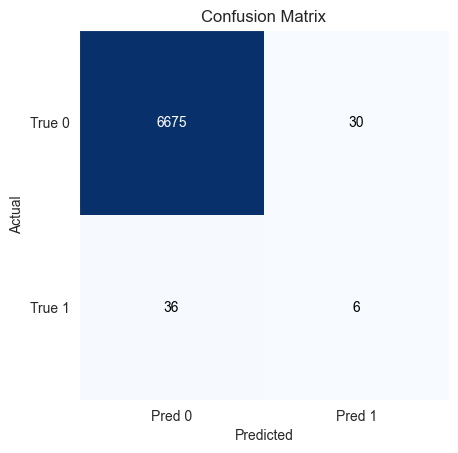

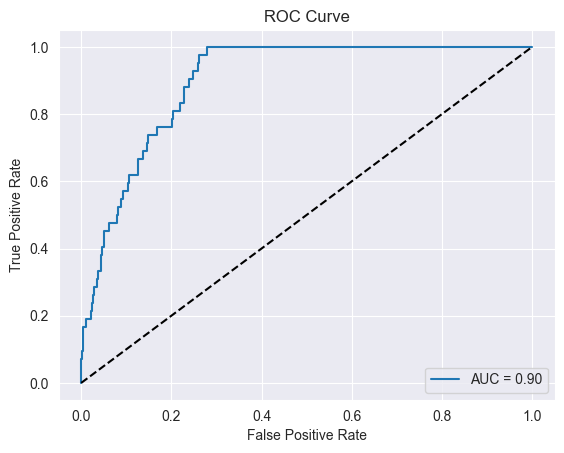

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
# Dự đoán trên test 
y_prob = best_model.predict(X_test_r).ravel()

# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred = (y_prob > optimal_threshold).astype(int)

# Classification Report
print("\n=== Classification Report on Test ===")
print(classification_report(y_test, y_pred, zero_division=0)) 

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Tắt grid 
ax.grid(False)

ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_prob) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()